# ***表情情感分类器***

# 0. 要解决的问题

① 此次你将使用单词向量表示来构建Emojifier表情符号。

② 你是否曾经想过让短信更具表现力？你的emojifier应用程序将帮助你做到这一点。

③ 因此，与其写“恭喜晋升！有机会喝杯咖啡聊天吧。爱你！” emojifier可以自动将其变成“恭喜升职👍！有机会一起喝咖啡☕️聊天吧，爱你！❤️”

① 你将实现一个模型，该模型输入一个句子（例如“让我们今晚去看棒球比赛！”），并找到最适合与该句子搭配使用的表情符号（⚾️）。

② 在许多表情符号界面中，你需要记住❤️是“心”符号而不是“爱”符号。但是使用单词向量，你会看到，即使你的训练集仅将几个单词与特定表情符号明确关联，你的算法也能够将测试集中的单词归纳并关联到同一表情符号，即使这些单词没有甚至不会出现在训练集中。

③ 这样，即使使用很小的训练集，也可以构建从句子到表情符号的准确分类器映射。

④ 在本练习中，你将从使用单词嵌入的基准模型（Emojifier-V1）开始，然后构建一个包含LSTM的更复杂的模型（Emojifier-V2）。

# 1. 导入库

In [1]:
import numpy as np
import emo_utils
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

# 2. 基准模型：Emojifier-V1

## 2.1 EMOJISET数据集

① 让我们从构建一个简单的baseline分类器开始。

② 你有一个很小的数据集（X，Y），其中：

 - X包含127个句子（字符串）
 - Y包含一个介于0到4之间的整数标签，对应于每个句子的表情符号

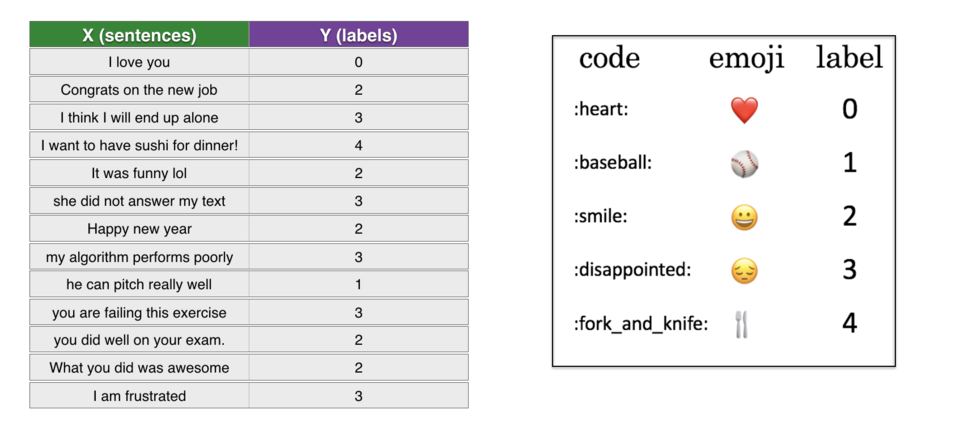

<center>图1：EMOJISET-5分类问题</center> 

③ 上面列出了一些例句。

④ 让我们使用下面的代码加载数据集。

 - 我们将数据集分为训练（127个示例）和测试（56个示例）集。

In [2]:
X_train, Y_train = emo_utils.read_csv('datasets/train_emoji.csv')
X_test, Y_test = emo_utils.read_csv('datasets/test.csv')

maxLen = len(max(X_train, key=len).split())

① 运行以下单元格以打印X_train和Y_train的句子的相应标签。

② 更改index以查看不同的示例。由于iPython笔记本使用的字体，爱心表情符号可能会是黑色而不是红色。

In [3]:
index  = 3
print(X_train[index], emo_utils.label_to_emoji(Y_train[index]))

Miss you so much ❤️


## 2.2 Emojifier-V1概述

① 在这一部分中，你将实现一个称为“Emojifier-v1”的基准模型。

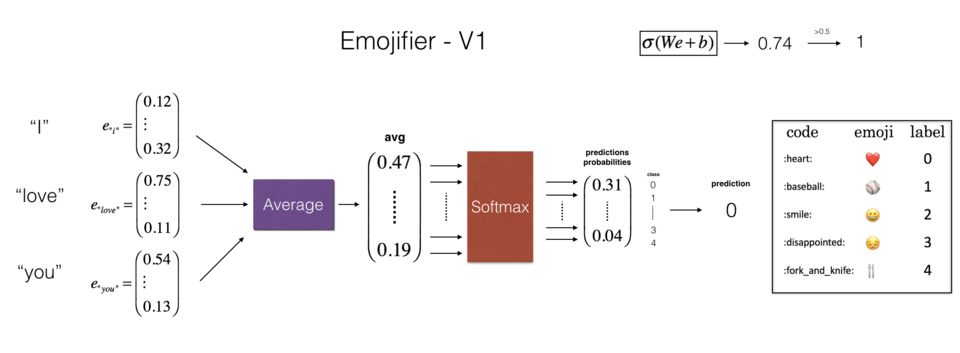

<center>图2：基准模型（Emojifier-V1）</center>

② 模型的输入是与句子相对应的字符串（例如，“I love you”。在代码中，输出将是维度为（1,5）的概率向量，然后将其传递到argmax层中以提取概率最大的表情符号的输出索引。

③ 为了使我们的标签成为适合训练softmax分类器的格式，让我们将从当前$Y$的维度$(m, 1)$转换为“独热表示”$(m, 5)$，其中每个 row是一个独热向量，提供了一个示例的标签，你可以使用下一个代码截取器来实现。

④ 在这里，Y_oh在变量名Y_oh_train和Y_oh_test中代表"Y-one-hot" ：

In [4]:
Y_oh_train = emo_utils.convert_to_one_hot(Y_train, C=5)
Y_oh_test = emo_utils.convert_to_one_hot(Y_test, C=5)

⑤ 让我们看看convert_to_one_hot()做了什么。随时更改index以输出不同的值。

In [5]:
index = 0 
print("{0}对应的独热编码是{1}".format(Y_train[index], Y_oh_train[index]))

3对应的独热编码是[0. 0. 0. 1. 0.]


⑥ 现在，所有数据都准备好输入到Emojify-V1模型。让我们实现模型！

## 2.3 实现Emojifier-V1

① 如图（2）所示，第一步是将输入句子转换为单词向量表示形式，然后将它们平均在一起。

② 与之前的练习类似，我们将使用预训练的50维GloVe嵌入。

③ 运行以下单元格以加载word_to_vec_map，其中包含所有向量表示形式。

In [6]:
word_to_index, index_to_word, word_to_vec_map = emo_utils.read_glove_vecs('datasets/glove.6B.50d.txt')

④ 你已加载：

 - word_to_index：字典将单词映射到词汇表中的索引（400,001个单词，有效索引范围是0到400,000）
 - index_to_word：字典从索引到词汇表中对应词的映射
 - word_to_vec_map：将单词映射到其GloVe向量表示的字典。

⑤ 运行以下单元格以检查其是否有效。

In [7]:
word = "cucumber"
index = 113317
print("单词{0}对应的索引是：{1}".format(word, word_to_index[word]))
print("索引{0}对应的单词是：{1}".format(index, index_to_word[index]))

单词cucumber对应的索引是：113317
索引113317对应的单词是：cucumber


⑥ 练习：实现sentence_to_avg()，你将需要执行两个步骤：
 1. 将每个句子转换为小写，然后将句子拆分为单词列表。X.lower()和X.split()可能有用。
 2. 对于句子中的每个单词，请访问其GloVe表示。然后，将所有这些值取平均值。

In [8]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    将句子转换为单词列表，提取其GloVe向量，然后将其平均。
    
    参数：
        sentence -- 字符串类型，从X中获取的样本。
        word_to_vec_map -- 字典类型，单词映射到50维的向量的字典
        
    返回：
        avg -- 对句子的均值编码，维度为(50,)
    """
    
    # 第一步：分割句子，转换为列表。
    words = sentence.lower().split()
    
    # 初始化均值词向量
    avg = np.zeros(50,)
    
    # 第二步：对词向量取平均。
    for w in words:
        avg += word_to_vec_map[w]
    avg = np.divide(avg, len(words))
    
    return avg

In [9]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


① 现在，你已经完成了所有实现model()函数的步骤。

② 使用sentence_to_avg()之后，你需要使平均值通过正向传播，计算损失，然后反向传播以更新softmax的参数。

③ 练习：实现图（2）中描述的model()函数。假设$Yoh$（“Y独热”）是输出标签的独热编码，则在正向传递中需要实现的公式和计算交叉熵损失的公式为：

$$z^{(i)} = W . avg^{(i)} + b$$

$$a^{(i)} = softmax(z^{(i)})$$

$$\mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$

④ 当然你有可能提出一个更有效的向量化实现。但是，由于我们始终使用for循环将句子一次转换为$avg^{(i)}$表示形式，因此这次我们不用理会。

⑤ 我们为你提供了一个函数softmax()。

In [10]:
def model(X, Y, word_to_vec_map, learning_rate=0.01, num_iterations=400):
    """
    在numpy中训练词向量模型。
    
    参数：
        X -- 输入的字符串类型的数据，维度为(m, 1)。
        Y -- 对应的标签，0-7的数组，维度为(m, 1)。
        word_to_vec_map -- 字典类型的单词到50维词向量的映射。
        learning_rate -- 学习率.
        num_iterations -- 迭代次数。
        
    返回：
        pred -- 预测的向量，维度为(m, 1)。
        W -- 权重参数，维度为(n_y, n_h)。
        b -- 偏置参数，维度为(n_y,)
    """
    np.random.seed(1)
    
    # 定义训练数量
    m = Y.shape[0]
    n_y = 5
    n_h = 50
    
    # 使用Xavier初始化参数
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # 将Y转换成独热编码
    Y_oh = emo_utils.convert_to_one_hot(Y, C=n_y)
    
    # 优化循环
    for t in range(num_iterations):
        for i in range(m):
            # 获取第i个训练样本的均值
            avg = sentence_to_avg(X[i], word_to_vec_map)
            
            # 前向传播
            z = np.dot(W, avg) + b
            a = emo_utils.softmax(z)
            
            # 计算第i个训练的损失
            cost = -np.sum(Y_oh[i]*np.log(a))
            
            # 计算梯度
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz
            
            # 更新参数
            W = W - learning_rate * dW
            b = b - learning_rate * db
        if t % 100 == 0:
            print("第{t}轮，损失为{cost}".format(t=t,cost=cost))
            pred = emo_utils.predict(X, Y, W, b, word_to_vec_map)
            
    return pred, W, b

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)


⑥ 运行下一个单元格来训练模型并学习softmax参数（W，b）。

In [12]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)

第0轮，损失为1.952049881281007
Accuracy: 0.3484848484848485
第100轮，损失为0.07971818726014807
Accuracy: 0.9318181818181818
第200轮，损失为0.04456369243681402
Accuracy: 0.9545454545454546
第300轮，损失为0.03432267378786059
Accuracy: 0.9696969696969697


## 2.4 检查测试集表现

① Great!你的模型在训练集上具有很高的准确性。现在让我们看看它如何在测试集上运行。

In [13]:
print("=====训练集====")
pred_train = emo_utils.predict(X_train, Y_train, W, b, word_to_vec_map)
print("=====测试集====")
pred_test = emo_utils.predict(X_test, Y_test, W, b, word_to_vec_map)

=====训练集====
Accuracy: 0.9772727272727273
=====测试集====
Accuracy: 0.8571428571428571


② 假设有5个类别，那么随机猜测的准确率将达到20％。在仅训练了127个示例之后，这是相当不错的表现。

③ 在训练集中，算法看到带有标签❤️的句子"I love you"。但是，在训练集中没有“adore”这个词汇，如果我们写“I adore you”会发生什么？

In [14]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "you are not happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = emo_utils.predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
emo_utils.print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
you are not happy ❤️


④ 惊人！由于adore具有与love类似的嵌入方式，因此该算法可以正确地推广到甚至从未见过的单词。

⑤ heart，dear，beloved或adore之类的单词具有类似于love的嵌入向量，因此也可以使用-随意修改上面的输入并尝试各种输入语句。看看效果如何？

⑥ 请注意，尽管这样并不能使"not feeling happy"正确。该算法忽略单词顺序，因此不善于理解"not happy."之类的短语。

⑦ 输出混淆矩阵还可以帮助你了解哪些类别对你的模型而言更加困难。混淆矩阵显示算法将一个类（“实际”类）的示例错误地标记为另一个类（“预测”类）的频率。

 	 ❤️ 	 ⚾ 	 😄 	 😞 	 🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


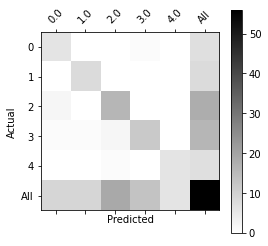

In [15]:
print(" \t {0} \t {1} \t {2} \t {3} \t {4}".format(emo_utils.label_to_emoji(0), emo_utils.label_to_emoji(1), \
                                                 emo_utils.label_to_emoji(2), emo_utils.label_to_emoji(3), \
                                                 emo_utils.label_to_emoji(4)))
import pandas as pd
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
emo_utils.plot_confusion_matrix(Y_test, pred_test)

⑧ 这部分你应该记住：

 - 即使有127个训练示例，你也可以获得合理的Emojifying模型。这是由于单词向量为你提供的泛化能力。
 - Emojify-V1在 "This movie is not good and not enjoyable" 等句子上表现不佳，因为它不理解单词的组合-只是将所有单词的嵌入向量平均在一起，而没有注意单词的顺序。在下一部分中，你将构建一个更好的算法。

# 3. Emojifier-V2：使用LSTM

① 让我们建立一个LSTM模型作为输入单词序列。此模型将能够考虑单词顺序。

② Emojifier-V2将继续使用预训练的单词嵌入来表示单词，但会将其输入到LSTM中，LSTM的工作是预测最合适的表情符号。

③ 运行以下单元格以加载Keras软件包。

## 3.1 导入库

In [16]:
import numpy as np
np.random.seed(0)
import keras
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.random.seed(1)
from keras.initializers import glorot_uniform

Using TensorFlow backend.
D:\11_Anaconda\envs\py3.6.3\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


## 3.2 模型概述

① 这是你将实现的Emojifier-v2：

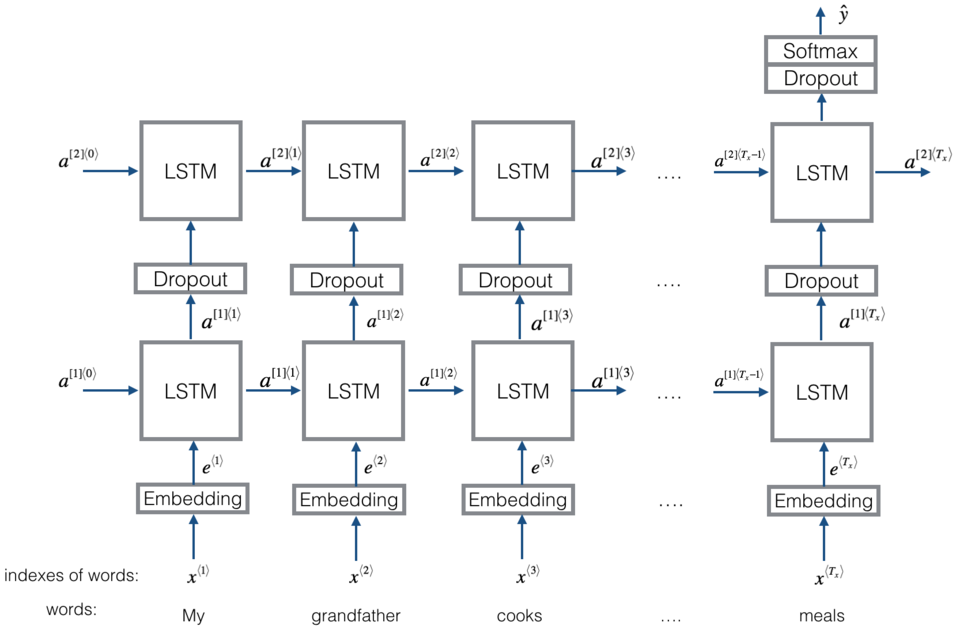

<center>图3：Emojifier-V2；2层LSTM序列分类器</center>

## 3.3 小批次处理

① 在本练习中，我们想使用mini-batch训练Keras。但是，大多数深度学习框架要求同一小批次中的所有序列具有相同的长度。

② 这就是向量化可以起作用的原因：如果你有3个单词的句子和4个单词的句子，那么它们所需的计算是不同的（一个LSTM需要3个步骤，一个LSTM需要4个步骤），所以同时做他们两个是不可能的。

③ 常见的解决方案是使用填充。具体来说，设置最大序列长度，并将所有序列填充为相同的长度。

 - 例如，最大序列长度为20，我们可以用“0”填充每个句子，以便每个输入句子的长度为20。
 - 因此，句子"i love you"将表示为$(e_{i}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$。
 - 在此示例中，任何长度超过20个单词的句子都必须被截断。

④ 选择最大序列长度的一种简单方法是仅选择训练集中最长句子的长度。

## 3.4 嵌入层

① 在Keras中，嵌入矩阵表示为“层”，并将正整数（对应于单词的索引）映射为固定大小的密集向量（嵌入向量）。

② 可以使用预训练的嵌入对其进行训练或初始化。在这一部分中，你将学习如何在Keras中创建Embedding()层，并使用之前在笔记本中加载的GloVe 50维向量对其进行初始化。

③ 因为我们的训练集很小，所以我们不会更新单词嵌入，而是将其值保持不变。但是在下面的代码中，我们将向你展示Keras如何允许你训练或固定该层。

④ Embedding()层采用大小（batch size，max input length）的整数矩阵作为输入。如下图所示，这对应于转换为索引列表（句子）的句子。

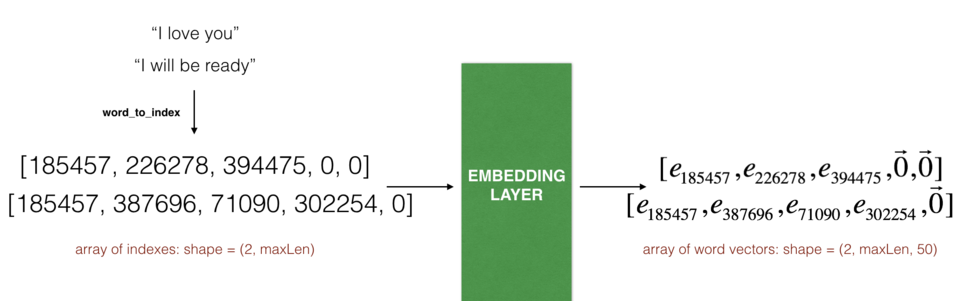

<center>图4：嵌入层</center>

① 此示例显示了两个示例通过嵌入层的传播。两者都被零填充到max_len=5的长度。最终的向量维度为(2,max_len,50)，因为我们使用的词嵌入为50维。

② 输入中的最大整数（即单词索引）应不大于词汇表的大小。该层输出一个维度数组(batch size, max input length, dimension of word vectors)。

③ 第一步是将所有训练语句转换为索引列表，然后对所有这些列表进行零填充，以使它们的长度为最长句子的长度。
 
④ 练习：实现以下函数，将X（字符串形式的句子数组）转换为与句子中单词相对应的索引数组。输出维度应使其可以赋予Embedding()（如图4所示）。

In [17]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    输入的是X（字符串类型的句子的数组），再转化为对应的句子列表，
    输出的是能够让Embedding()函数接受的列表或矩阵（参见图4）。
    
    参数：
        X -- 句子数组，维度为(m, 1)
        word_to_index -- 字典类型的单词到索引的映射
        max_len -- 最大句子的长度，数据集中所有的句子的长度都不会超过它。
        
    返回：
        X_indices -- 对应于X中的单词索引数组，维度为(m, max_len)
    """
    
    m = X.shape[0]  # 训练集数量
    # 使用0初始化X_indices
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        # 将第i个居住转化为小写并按单词分开。
        sentences_words = X[i].lower().split()
        
        # 初始化j为0
        j = 0
        
        # 遍历这个单词列表
        for w in sentences_words:
            # 将X_indices的第(i, j)号元素为对应的单词索引
            X_indices[i, j] = word_to_index[w]
            
            j += 1
            
    return X_indices


① 运行以下单元格以检查sentences_to_indices()的作用，并检查结果。

In [18]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


② 让我们使用预先训练的单词向量在Keras中构建Embedding()层。建立此层后，你将把sentences_to_indices()的输出作为输入传递给它，而Embedding()层将返回句子的单词嵌入。

③ 练习：实现pretrained_embedding_layer()。你将需要执行以下步骤：

 - 将嵌入矩阵初始化为具有正确维度的零的numpy数组。
 - 使用从word_to_vec_map中提取的所有词嵌入来填充嵌入矩阵。
 - 定义Keras嵌入层。 使用Embedding()。确保在调用 Embedding()时设置trainable = False来使该层不可训练。如果要设置trainable = True，那么它将允许优化算法修改单词嵌入的值。
 - 将嵌入权重设置为等于嵌入矩阵

In [19]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    创建Keras Embedding()层，加载已经训练好了的50维GloVe向量
    
    参数：
        word_to_vec_map -- 字典类型的单词与词嵌入的映射
        word_to_index -- 字典类型的单词到词汇表（400,001个单词）的索引的映射。
        
    返回：
        embedding_layer() -- 训练好了的Keras的实体层。
    """
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["cucumber"].shape[0]
    
    # 初始化嵌入矩阵
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # 将嵌入矩阵的每行的“index”设置为词汇“index”的词向量表示
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    
    # 定义Keras的embbeding层
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    
    # 构建embedding层。
    embedding_layer.build((None,))
    
    # 将嵌入层的权重设置为嵌入矩阵。
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer


In [20]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


## 3.5 构建Emojifier-V2

① 现在让我们构建Emojifier-V2模型，你将使用已构建的嵌入层来执行此操作，并将其输出提供给LSTM网络。

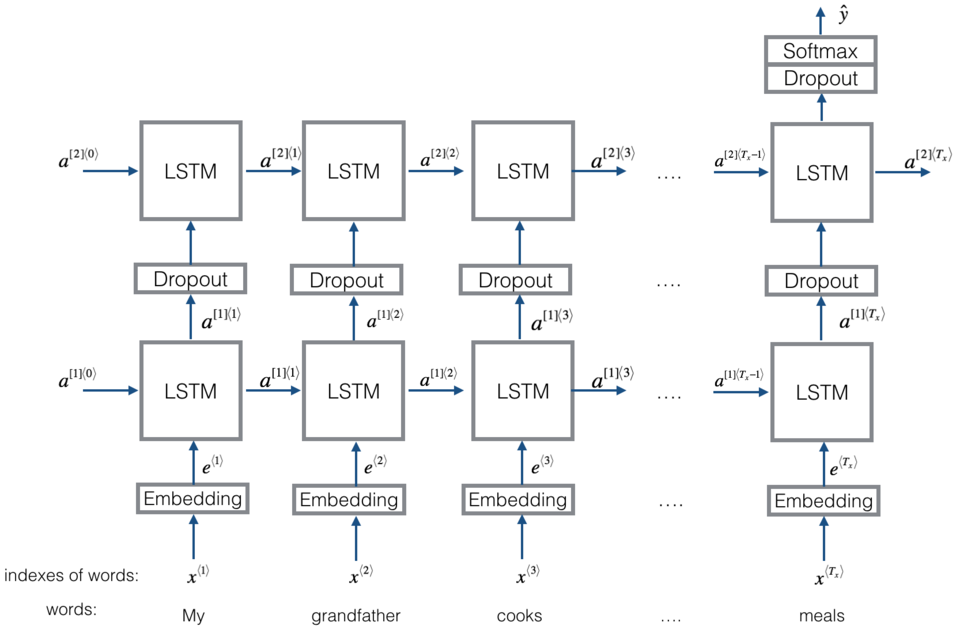

<center>图5：Emojifier-v2；2层LSTM序列分类器</center>

② 练习：实现Emojify_V2()，它构建图3所示结构的Keras图。

 - 该模型将由input_shape定义的维度为(m, max_len, )的句子数组作为输入。
 - 它应该输出形状为softmax的概率向量(m, C = 5)。
 - 你可能需要Input(shape = ..., dtype = '...')，LSTM(), Dropout(), Dense(), 和 Activation()。

In [21]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    实现Emojify-V2模型的计算图
    
    参数：
        input_shape -- 输入的维度，通常是(max_len,)
        word_to_vec_map -- 字典类型的单词与词嵌入的映射。
        word_to_index -- 字典类型的单词到词汇表（400,001个单词）的索引的映射。
    
    返回：
        model -- Keras模型实体
    """
    # 定义sentence_indices为计算图的输入，维度为(input_shape,)，类型为dtype 'int32' 
    sentence_indices = Input(input_shape, dtype='int32')
    
    # 创建embedding层
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # 通过嵌入层传播sentence_indices，你会得到嵌入的结果
    embeddings = embedding_layer(sentence_indices)
    
    # 通过带有128维隐藏状态的LSTM层传播嵌入
    # 需要注意的是，返回的输出应该是一批序列。
    X = LSTM(128, return_sequences=True)(embeddings)
    # 使用dropout，概率为0.5
    X = Dropout(0.5)(X)
    # 通过另一个128维隐藏状态的LSTM层传播X
    # 注意，返回的输出应该是单个隐藏状态，而不是一组序列。
    X = LSTM(128, return_sequences=False)(X)
    # 使用dropout，概率为0.5
    X = Dropout(0.5)(X)
    # 通过softmax激活的Dense层传播X，得到一批5维向量。
    X = Dense(5)(X)
    # 添加softmax激活
    X = Activation('softmax')(X)
    
    # 创建模型实体
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

① 运行以下单元格以创建你的模型并检查其总结。

② 由于数据集中的所有句子均少于10个单词，因此我们选择“max_len = 10”。

③ 你应该看到你的体系结构，它使用“20,223,927”个参数，其中20,000,050（词嵌入）是不可训练的，其余223,877是可训练的。

④ 因为我们的词汇量有400,001个单词（有效索引从0到400,000），所以有400,001 * 50 = 20,000,050个不可训练的参数。

In [22]:
max_Len=10
model = Emojify_V2((max_Len,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

① 与之前一样，在Keras中创建模型后，你需要对其进行编译并定义要使用的损失，优化器和指标。

② 使用categorical_crossentropy损失，adam优化器和['accuracy']度量来编译模型：

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

① 现在该训练你的模型了。你的Emojifier-V2模型以(m, max_len) 维度数组作为输入，并输出维度概率矢量 (m, number of classes)。

② 因此，我们必须将X_train（作为字符串的句子数组）转换为X_train_indices（作为单词索引列表的句子数组），并将Y_train（作为索引的标签）转换为Y_train_oh（作为独热向量的标签）。

In [24]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = emo_utils.convert_to_one_hot(Y_train, C = 5)

③ 在X_train_indices和Y_train_oh上拟合Keras模型。我们将使用 epochs = 50和batch_size = 32。

In [25]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
132/132 [==============================] - 1s 7ms/step - loss: 1.6083 - acc: 0.1970
Epoch 2/50
132/132 [==============================] - 0s 398us/step - loss: 1.5324 - acc: 0.2955
Epoch 3/50
132/132 [==============================] - 0s 414us/step - loss: 1.5011 - acc: 0.3258
Epoch 4/50
132/132 [==============================] - 0s 446us/step - loss: 1.4391 - acc: 0.3561
Epoch 5/50
132/132 [==============================] - 0s 443us/step - loss: 1.3481 - acc: 0.4545
Epoch 6/50
132/132 [==============================] - 0s 433us/step - loss: 1.2347 - acc: 0.5152
Epoch 7/50
132/132 [==============================] - 0s 443us/step - loss: 1.1771 - acc: 0.4470
Epoch 8/50
132/132 [==============================] - 0s 450us/step - loss: 1.0555 - acc: 0.5758
Epoch 9/50
132/132 [==============================] - 0s 512us/step - loss: 0.8781 - acc: 0.7121
Epoch 10/50
132/132 [==============================] - 0s 455us/step - loss: 0.8246 - acc: 0.6970
Epoch 11/50
132/132 [==========

④ 你的模型在训练集上的表现应接近100% accuracy。你获得的确切精度可能会有所不同。运行以下单元格以在测试集上评估模型。

In [26]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = emo_utils.convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)

print("Test accuracy = ", acc)

56/56 [==============================] - 0s 3ms/step
Test accuracy =  0.8214285629136222


⑤ 你应该获得80％到95％的测试精度。运行下面的单元格以查看标签错误的示例。

In [27]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('正确表情：'+ emo_utils.label_to_emoji(Y_test[i]) + '   预测结果： '+ X_test[i] + emo_utils.label_to_emoji(num).strip())

正确表情：😄   预测结果： she got me a nice present	❤️
正确表情：😞   预测结果： work is hard	😄
正确表情：😞   预测结果： This girl is messing with me	❤️
正确表情：🍴   预测结果： any suggestions for dinner	😄
正确表情：❤️   预测结果： I love taking breaks	😞
正确表情：😄   预测结果： you brighten my day	❤️
正确表情：😄   预测结果： will you be my valentine	❤️
正确表情：🍴   预测结果： See you at the restaurant	😄
正确表情：😞   预测结果： go away	⚾
正确表情：🍴   预测结果： I did not have breakfast ❤️


⑥ 现在，你可以按照自己的示例进行尝试。在下面写下你自己的句子。

In [28]:
x_test = np.array(['you are so beautiful'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  emo_utils.label_to_emoji(np.argmax(model.predict(X_test_indices))))

you are so beautiful ❤️


① 此前，Emojify-V1模型没有正确标记"not feeling happy,"，但是我们的Emojiy-V2正确实现了。（Keras的输出每次都是稍微随机的，因此你可能无法获得相同的结果。）

② 由于训练集很小且有很多否定的例子，因此当前模型在理解否定（例如"not happy"）方面仍然不是很健壮。

③ 但是，如果训练集更大，则LSTM模型在理解此类复杂句子方面将比Emojify-V1模型好得多。

④ 你应该记住：
 - 如果你的NLP任务的训练集很小，则使用单词嵌入可以大大帮助你的算法。词嵌入功能使你的模型可以在测试集中甚至没有出现在训练集中的词上使用。
 - Keras（和大多数其他深度学习框架）中的训练序列模型需要一些重要的细节：
    - 要使用小批量，需要填充序列，以使小批量中的所有示例都具有相同的长度。
    - 可以使用预训练的值来初始化Embedding()层。这些值可以是固定的，也可以在数据集中进一步训练。但是，如果你标记的数据集很小，则通常不值得尝试训练大量预训练的嵌入。
    - LSTM()具有一个名为return_sequences的标志，用于确定你是要返回每个隐藏状态还是仅返回最后一个状态。
    - 你可以在LSTM()之后紧接使用Dropout()来规范你的网络。